# Import

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import numpy as np

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)

# Data Check

- sales_train.csv - train 데이터 ( 2013년 1월부터 2015년 10월 까지의 일일 데이터 )
- test.csv - test데이터
- sample_submission.csv - submission 샘플 데이터
- items.csv - 품목 / 제품에 대한 정보
- item_categories.csv - item 카테고리에 대한 정보
- shops.csv- 상점에 대한 보충정보


- ID -test 세트 내의 (shop과 item)에 관한 튜플을 나타내는 id
- shop_id - 상점의 고유 식별자
- item_id - 제품의 고유 식별자
- item_category_id - 상품 카테고리의 고유 식별자
- item_cnt_day - 팔린 상품의 개수 
- item_price - item에 관한 가격
- date - 해당 날짜
- date_block_num - 연속된 월 번호 ( 2013년 1월은 0 2013년 2월은 2 ~ 2015년 10월은 33 )
- item_name - 상품 이름
- shop_name - 상점 이름
- item_category_name - 상품 카테고리 이름

In [2]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('test.csv').set_index('ID')

In [62]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00


In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


# EDA

### < 중복 체크 >

In [8]:
sum(train.duplicated()), sum(test.duplicated())

(6, 0)

In [9]:
sum(items.duplicated()), sum(cats.duplicated()), sum(shops.duplicated())

(0, 0, 0)

train 데이터에만 중복된 행이 6개 있음

In [10]:
train[train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


#### 중복된 행 제거

In [11]:
train.drop_duplicates(inplace=True)
sum(train.duplicated())   # 중복 재확인

0

### < 결측치 체크 >

In [12]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [13]:
test.isnull().sum()

shop_id    0
item_id    0
dtype: int64

train, test 데이터셋에는 결측치 X

### < 이상치(Outlier) 체크 >

box plot을 통해 이상치 체크

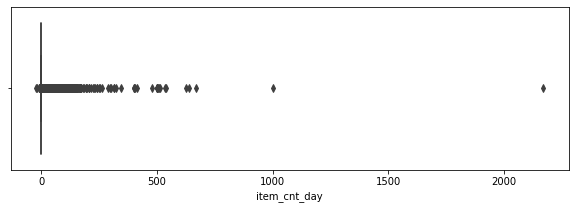

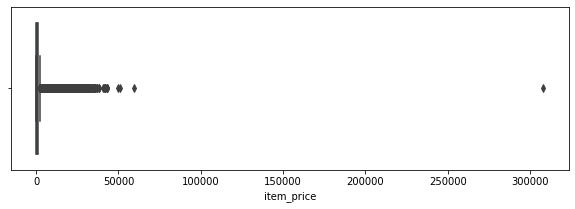

In [14]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=train)

item_cnt_day 에서는 1000이 넘으면, item_price에서는 100000이 넘으면 이상치로 보고 삭제

In [15]:
train = train[train.item_price<100001]
train = train[train.item_cnt_day<1001]

그래프를 보았을 때, 각 column에서 음수의 값을 가지는 행이 있어보임

In [16]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935841e+06,2.935841e+06,2.935841e+06,2.935841e+06,2.935841e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.907492e+02,1.241903e+00
std,9.422989e+00,1.622697e+01,6.324294e+03,1.720492e+03,2.292965e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,1.000000e+03


음수의 값을 가지는 행 제거해줌

In [17]:
train = train[train.item_cnt_day >= 0]
train = train[train.item_price >= 0]

### < Shops 전처리 >

#### 각각의 shop 이름은 도시 이름으로 시작되는 특징이 있음 
수치 데이터가 아닌 문자 데이터는 데이터 분석이 번거롭기 때문에 문자 데이터를 수치 데이터로 Encoding

In [18]:
shops.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
shop_name,"!Якутск Орджоникидзе, 56 фран","!Якутск ТЦ ""Центральный"" фран","Адыгея ТЦ ""Мега""","Балашиха ТРК ""Октябрь-Киномир""","Волжский ТЦ ""Волга Молл""","Вологда ТРЦ ""Мармелад""","Воронеж (Плехановская, 13)","Воронеж ТРЦ ""Максимир""","Воронеж ТРЦ Сити-Парк ""Град""",Выездная Торговля,Жуковский ул. Чкалова 39м?,Жуковский ул. Чкалова 39м²,Интернет-магазин ЧС,"Казань ТЦ ""Бехетле""","Казань ТЦ ""ПаркХаус"" II","Калуга ТРЦ ""XXI век""","Коломна ТЦ ""Рио""","Красноярск ТЦ ""Взлетка Плаза""","Красноярск ТЦ ""Июнь""","Курск ТЦ ""Пушкинский""","Москва ""Распродажа""","Москва МТРЦ ""Афи Молл""",Москва Магазин С21,"Москва ТК ""Буденовский"" (пав.А2)","Москва ТК ""Буденовский"" (пав.К7)","Москва ТРК ""Атриум""","Москва ТЦ ""Ареал"" (Беляево)","Москва ТЦ ""МЕГА Белая Дача II""","Москва ТЦ ""МЕГА Теплый Стан"" II","Москва ТЦ ""Новый век"" (Новокосино)","Москва ТЦ ""Перловский""","Москва ТЦ ""Семеновский""","Москва ТЦ ""Серебряный Дом""","Мытищи ТРК ""XL-3""","Н.Новгород ТРЦ ""РИО""","Н.Новгород ТРЦ ""Фантастика""","Новосибирск ТРЦ ""Галерея Новосибирск""","Новосибирск ТЦ ""Мега""","Омск ТЦ ""Мега""","РостовНаДону ТРК ""Мегацентр Горизонт""","РостовНаДону ТРК ""Мегацентр Горизонт"" Островной","РостовНаДону ТЦ ""Мега""","СПб ТК ""Невский Центр""","СПб ТК ""Сенная""","Самара ТЦ ""Мелодия""","Самара ТЦ ""ПаркХаус""","Сергиев Посад ТЦ ""7Я""","Сургут ТРЦ ""Сити Молл""","Томск ТРЦ ""Изумрудный Город""","Тюмень ТРЦ ""Кристалл""","Тюмень ТЦ ""Гудвин""","Тюмень ТЦ ""Зеленый Берег""","Уфа ТК ""Центральный""","Уфа ТЦ ""Семья"" 2","Химки ТЦ ""Мега""",Цифровой склад 1С-Онлайн,"Чехов ТРЦ ""Карнавал""","Якутск Орджоникидзе, 56","Якутск ТЦ ""Центральный""","Ярославль ТЦ ""Альтаир"""
shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59


0번은 57번과, 1번은 58번과, 10번은 11번과 사소한 문자 빼고는 동일한 이름을 가진 것을 알 수 있음

In [19]:
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

In [20]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

In [21]:
cities = shops['shop_name'].str.split(' ').map(lambda row: row[0])
cities.unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

도시 'Yakutsk'는 '!Якутск'와 'Якутск'로 표현됨

In [22]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda row: row[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [23]:
# Encoding
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [24]:
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### < category 전처리 >

In [25]:
type_encoder = LabelEncoder()
cats['split_name'] = cats['item_category_name'].str.split(' - ') # -를 기준으로 나눔
cats['type'] = cats['split_name'].map(lambda x: x[0].strip())   # 나눠진 단어를 기준으로 type column 생성
cats['type_code'] = type_encoder.fit_transform(cats['type'])    # type 수치데이터로 encoding

In [26]:
cats.head()

,item_category_name,item_category_id,split_name,type,type_code
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,0
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,1
2,Аксессуары - PS3,2,"[Аксессуары, PS3]",Аксессуары,1
3,Аксессуары - PS4,3,"[Аксессуары, PS4]",Аксессуары,1
4,Аксессуары - PSP,4,"[Аксессуары, PSP]",Аксессуары,1


In [27]:
# subtype
subtype_encoder = LabelEncoder()
cats['subtype'] = cats['split_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = subtype_encoder.fit_transform(cats['subtype'])      # sub-type Encoding
cats = cats[['item_category_id', 'type_code', 'subtype_code']]             # 수치 데이터만 남겨놓음

In [28]:
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11
2,2,1,12
3,3,1,13
4,4,1,15


### < Item 전처리 >

이미 item_id와 item_category_id가 숫자로 매핑되어 있어 name만 drop해주면 됨

In [29]:
items.drop(['item_name'], axis=1, inplace=True)
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


#### 이제 shops, cats, items 모두 Encoding됨

#### test 데이터셋을 보면,

In [30]:
test.shop_id.value_counts()

59    5100
16    5100
28    5100
26    5100
25    5100
24    5100
22    5100
21    5100
19    5100
18    5100
15    5100
58    5100
14    5100
12    5100
11    5100
7     5100
6     5100
5     5100
4     5100
3     5100
31    5100
34    5100
35    5100
36    5100
57    5100
56    5100
55    5100
53    5100
52    5100
50    5100
49    5100
48    5100
47    5100
46    5100
45    5100
44    5100
42    5100
41    5100
39    5100
38    5100
37    5100
2     5100
Name: shop_id, dtype: int64

In [31]:
len(test.shop_id.unique())

42

총 42개의 shop_id가 있으며 각 shop_id마다 5,100개의 item이 있다.

In [32]:
len(set(test.item_id) - set(train.item_id))

363

test에는 있지만 train에는 없는 item_id가 총 363개 있음.

#### 이는 train 데이터에 모든 종류의 item이 있지는 않다는 것을 의미 -> 363개의 item에 대해서는 0개가 판매된 것으로 예측해야 함



###  'date_block_num', 'shop_id', 'item_id'로 구성된 Matrix 만들기

In [33]:
num_date_block_num = len(train.date_block_num.value_counts())
num_date_block_num

34

itertools : 반복 가능한 데이터 스트림을 처리하는 데 유용한 함수와 제너레이터가 포함된 모듈

itertools.product() : 곱집합 구해줌 (모든 원소를 한번씩 다 곱해줌 -> 모든 경우의 수 확인)

In [34]:
import itertools

ts = time.time()   
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append(np.array(list(itertools.product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)  # vstack : 배열 붙이기

# shop_id : 42개 item_id : 5100개 따라서 범위 조정해줌
# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)
time.time()-ts

29.756669998168945

In [35]:
matrix.head()

,date_block_num,shop_id,item_id
114838,0,2,19
117076,0,2,27
120551,0,2,28
118242,0,2,29
114531,0,2,32


###  train의 Groupby를 통한 Monthly Sales 구하기
train 데이터셋에 revenue를 추가함

In [36]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


In [37]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [59]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00


In [39]:
# Groupby
# 기준이 될 열 : 'date_block_num', 'shop_id', 'item_id'
# agg({'item_cnt_day': ['sum']}) : 'item_cnt_day' 열은 sum 형식으로 보여줌
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})

In [40]:
group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              2       27               1.0
                       33               1.0
                       317              1.0
                       438              1.0
                       471              2.0

In [41]:
group.columns = ['item_cnt_month']   # 칼럼 이름 바꾸기
group.reset_index(inplace=True)     # 인덱스 리셋

In [42]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0



#### matrix와 group 합치기

In [60]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [44]:
matrix.head()

,date_block_num,shop_id,item_id
114838,0,2,19
117076,0,2,27
120551,0,2,28
118242,0,2,29
114531,0,2,32


In [45]:
matrix = pd.merge(matrix, group, how='left')

In [46]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,NaN
1,0,2,27,1.0
2,0,2,28,NaN
3,0,2,29,NaN
4,0,2,32,NaN


여기서 나타나는 NaN은 0이므로 0으로 바꾸어주고, item_cnt_month의 범위를 (0, 30)으로 지정함 (30이 넘어가는 수는 그다지 많지 않기 때문)

예측의 정확성을 위해 범위도 float16으로 바꾸어줌 (나중에 test데이터와 합쳤을 때, downcasting되는 것을 막기 위함)

In [47]:
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 30).astype(np.float16))

In [48]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


이제, matrx에는 모든 date_block_num, shop_id, item_id에 따른 월별 판매량이 저장되어 있음

###  Matrix에 테스트 데이터 붙이기

In [49]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [50]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # for 34 month(test 데이터셋) -> item_cnt_month값 0으로 설정해야함
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [51]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month
11098703,34,45,18454,0.0
11098704,34,45,16188,0.0
11098705,34,45,15757,0.0
11098706,34,45,19648,0.0
11098707,34,45,969,0.0


train 데이터에 없는 363개의 item에 대한 처리 완료

### Matrix에 shops, items, cats merge하기

In [52]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [53]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,6
1,0,2,27,1.0,0,19,5,12
2,0,2,28,0.0,0,30,8,57
3,0,2,29,0.0,0,23,5,18
4,0,2,32,0.0,0,40,11,6


In [54]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
11098703,34,45,18454,0.0,20,55,13,4
11098704,34,45,16188,0.0,20,64,14,44
11098705,34,45,15757,0.0,20,55,13,4
11098706,34,45,19648,0.0,20,40,11,6
11098707,34,45,969,0.0,20,37,11,1
